In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'absolute'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0527070343286735 	 Validation loss: 2.0130698761697543 	 
  1%|          | 574/57400 [02:56<4:57:52,  3.18it/s]
Epoch 2 	 Training loss: 1.9987519605649888 	 Validation loss: 1.9982628155562838 	 
  2%|▏         | 1148/57400 [06:01<4:00:19,  3.90it/s]
Epoch 3 	 Training loss: 1.9861068754661373 	 Validation loss: 1.9907544831098136 	 
  3%|▎         | 1722/57400 [09:04<4:39:39,  3.32it/s]
Epoch 4 	 Training loss: 1.9769905381917123 	 Validation loss: 1.9829049009387776 	 
  4%|▍         | 2296/57400 [12:30<4:31:32,  3.38it/s]
Epoch 5 	 Training loss: 1.9708774141733654 	 Validation loss: 1.9842640585818534 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [16:06<4:16:05,  3.55it/s]
Epoch 6 	 Training loss: 1.965905956482638 	 Validation loss: 1.9725116390292927 	 
  6%|▌         | 3444/57400 [19:10<4:33:31,  3.29it/s]
Epoch 7 	 Training loss: 1.9658099541680738 	 Validation loss: 1.9753637798761918 	 

1 epoch without improvement
  7%|▋         | 40

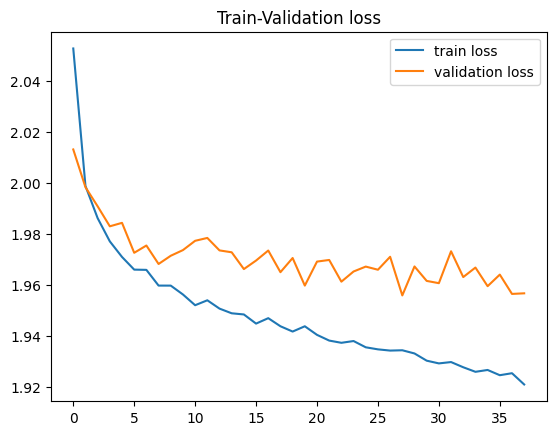

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_absolute_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6578282828282829, 'precision': 0.6578282828282829, 'f1': 0.6578282828282829, 'accuracy': 0.6578282828282829}, 'as': {'recall': 0.7222946544980443, 'precision': 0.7222946544980443, 'f1': 0.7222946544980443, 'accuracy': 0.7222946544980443}, 'about': {'recall': 0.826530612244898, 'precision': 0.826530612244898, 'f1': 0.826530612244898, 'accuracy': 0.826530612244898}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}, 'as': {'recall': 0.7196969696969697, 'precision': 0.7196969696969697, 'f1': 0.7196969696969698, 'accuracy': 0.7196969696969697}, 'about': {'recall': 0.8385416666666666, 'precision': 0.8385416666666666, 'f1': 0.8385416666666666, 'accuracy': 0.8385416666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6062992125984252, 'precision': 0.6062992125984252, 'f1': 0.6062992125984252, 'accuracy': 0.6062992125984252}, 'as': 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0529939634043997 	 Validation loss: 2.018875473636692 	 
  1%|          | 574/57400 [03:04<4:51:21,  3.25it/s]
Epoch 2 	 Training loss: 1.9947276028191172 	 Validation loss: 1.9974591812845004 	 
  2%|▏         | 1148/57400 [06:37<5:01:28,  3.11it/s]
Epoch 3 	 Training loss: 1.978673772321761 	 Validation loss: 1.9850857096203303 	 
  3%|▎         | 1722/57400 [10:12<4:50:23,  3.20it/s]
Epoch 4 	 Training loss: 1.9718582133798235 	 Validation loss: 1.9771485874208354 	 
  4%|▍         | 2296/57400 [13:19<4:46:30,  3.21it/s]
Epoch 5 	 Training loss: 1.9675400664166707 	 Validation loss: 1.9796689425484608 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [16:27<4:57:01,  3.06it/s]
Epoch 6 	 Training loss: 1.9643857952609711 	 Validation loss: 1.970078310724032 	 
  6%|▌         | 3444/57400 [19:34<4:36:08,  3.26it/s]
Epoch 7 	 Training loss: 1.961480143385897 	 Validation loss: 1.978801573737193 	 

1 epoch without improvement
  7%|▋         | 4018/5

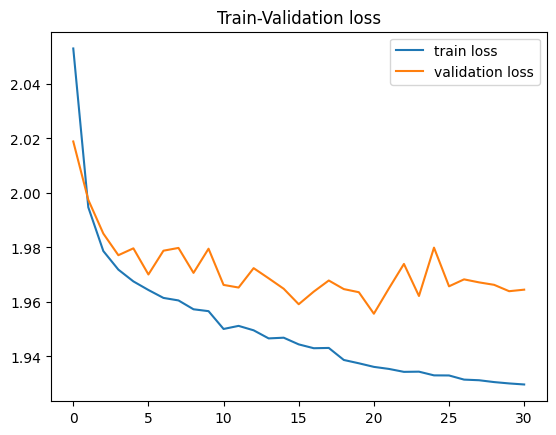

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_absolute_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6590909090909091, 'precision': 0.6590909090909091, 'f1': 0.6590909090909091, 'accuracy': 0.6590909090909091}, 'as': {'recall': 0.7105606258148631, 'precision': 0.7105606258148631, 'f1': 0.710560625814863, 'accuracy': 0.7105606258148631}, 'about': {'recall': 0.8176020408163265, 'precision': 0.8176020408163265, 'f1': 0.8176020408163265, 'accuracy': 0.8176020408163265}} 

Evaluación en etiquetas male
{'to': {'recall': 0.6763990267639902, 'precision': 0.6763990267639902, 'f1': 0.6763990267639902, 'accuracy': 0.6763990267639902}, 'as': {'recall': 0.6893939393939394, 'precision': 0.6893939393939394, 'f1': 0.6893939393939394, 'accuracy': 0.6893939393939394}, 'about': {'recall': 0.8255208333333334, 'precision': 0.8255208333333334, 'f1': 0.8255208333333334, 'accuracy': 0.8255208333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6404199475065617, 'precision': 0.6404199475065617, 'f1': 0.6404199475065617, 'accuracy': 0.6404199475065617}, 'as

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0580057539175614 	 Validation loss: 2.0118015014519126 	 
  1%|          | 574/57400 [03:06<4:03:04,  3.90it/s]
Epoch 2 	 Training loss: 1.9923249464417168 	 Validation loss: 1.9885648771867914 	 
  2%|▏         | 1148/57400 [06:13<4:10:17,  3.75it/s]
Epoch 3 	 Training loss: 1.9782070966132426 	 Validation loss: 1.985366534378569 	 
  3%|▎         | 1722/57400 [09:21<3:59:11,  3.88it/s]
Epoch 4 	 Training loss: 1.9728645584724507 	 Validation loss: 1.9748832856194447 	 
  4%|▍         | 2296/57400 [12:27<4:02:45,  3.78it/s]
Epoch 5 	 Training loss: 1.9676730383563956 	 Validation loss: 1.9799437805757685 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [15:34<4:57:51,  3.05it/s]
Epoch 6 	 Training loss: 1.9655105469534206 	 Validation loss: 1.9777981022656974 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [19:04<4:36:53,  3.25it/s]
Epoch 7 	 Training loss: 1.9609281742614322 	 Validation loss: 1.9800491716902135 	 

3 epoch without im

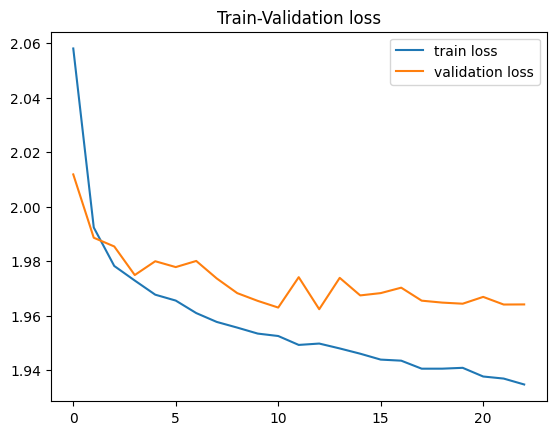

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_absolute_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6603535353535354, 'precision': 0.6603535353535354, 'f1': 0.6603535353535354, 'accuracy': 0.6603535353535354}, 'as': {'recall': 0.7131681877444589, 'precision': 0.7131681877444589, 'f1': 0.713168187744459, 'accuracy': 0.7131681877444589}, 'about': {'recall': 0.8188775510204082, 'precision': 0.8188775510204082, 'f1': 0.8188775510204082, 'accuracy': 0.8188775510204082}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}, 'as': {'recall': 0.6994949494949495, 'precision': 0.6994949494949495, 'f1': 0.6994949494949495, 'accuracy': 0.6994949494949495}, 'about': {'recall': 0.8463541666666666, 'precision': 0.8463541666666666, 'f1': 0.8463541666666666, 'accuracy': 0.8463541666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6141732283464567, 'precision': 0.6141732283464567, 'f1': 0.6141732283464567, 'accuracy': 0.6141732283464567}, 'as

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8210034013605442, 'precision': 0.8210034013605442, 'f1': 0.8210034013605442, 'accuracy': 0.8210034013605442}
Métricas etiqueta male: {'recall': 0.8368055555555556, 'precision': 0.8368055555555556, 'f1': 0.8368055555555556, 'accuracy': 0.8368055555555556}
Métricas etiqueta female:  {'recall': 0.8058333333333333, 'precision': 0.8058333333333333, 'f1': 0.8058333333333333, 'accuracy': 0.8058333333333333}

 to
Resultado global: {'recall': 0.6590909090909091, 'precision': 0.6590909090909091, 'f1': 0.6590909090909091, 'accuracy': 0.6590909090909091}
Métricas etiqueta male: {'recall': 0.6950527169505272, 'precision': 0.6950527169505272, 'f1': 0.6950527169505272, 'accuracy': 0.6950527169505272}
Métricas etiqueta female:  {'recall': 0.6202974628171479, 'precision': 0.6202974628171479, 'f1': 0.6202974628171479, 'accuracy': 0.6202974628171479}

 as
Resultado global: {'recall': 0.7153411560191221, 'precision': 0.7153411560191221, 'f1': 0.7